In [12]:
import numpy as np
from scipy import io
from scipy import sparse
from scipy.sparse import csgraph
from scipy import fftpack
from scipy import signal
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib import collections
import mpl_toolkits.mplot3d.art3d as art3d
import seaborn as sns
import igraph

%matplotlib inline

In [13]:
sns.set_palette('husl')

# Set up plotting

In [14]:
def graph3d(x, y, z, **kwargs):
    xmin = kwargs.setdefault('xmin', x.min())
    xmax = kwargs.setdefault('xmax', x.max())
    ymin = kwargs.setdefault('ymin', y.min())
    ymax = kwargs.setdefault('ymax', y.max())
    zmin = kwargs.setdefault('zmin', z.min())
    zmax = kwargs.setdefault('zmax', z.max())
    
    if 'fig' in kwargs:
        fig = kwargs['fig']
    else:
        fig = plt.figure(figsize=(6,6))
    if 'ax' in kwargs:
        ax = kwargs['ax']
    else:
        ax = fig.add_subplot(1, 1, 1, projection='3d')

    ax._axis3don = False

    for xi, yi, zi in zip(x, y, z):
        if zi >= 0:
            color = 'b'
        else:
            color = 'r'
        line=art3d.Line3D(*zip((xi, yi, 0), (xi, yi, zi)), marker='o',
                          markersize=2, markevery=(1, 1), color=color)
        ax.add_line(line)
    if 'lc' in kwargs:
        ax.add_collection3d(kwargs['lc'])
    
    ax.set_xlim3d(xmin, xmax)
    ax.set_ylim3d(ymin, ymax)
    ax.set_zlim3d(zmin, zmax)
    ax.set_facecolor('white')
    ax.view_init(elev=30., azim=300)
    plt.tight_layout()

# Review of the Fourier Transform

In the traditional Euclidean domain, we can find the frequency-domain
representation of a time series signal using the Fourier transform:

#### Classical Fourier Transform
  \begin{equation}
    \hat{f}(\xi) = \int_{-\infty}^{\infty} f(t) e^{-2 \pi j \xi t} dt 
  \end{equation}

$\hat{f}$ is an expansion of $f$ in terms of complex exponentials, which are the
eigenfunctions of the Laplace operator:

#### Classical Fourier transform in terms of the Laplace operator
  \begin{equation}
    - \Delta (e^{2 \pi j \xi t}) = \frac{\partial^2}{\partial t^2} e^{2 \pi j \xi t} = 4 \pi^2 \xi^2 e^{2 \pi j \xi t} = k e^{2 \pi j \xi t}
  \end{equation}


In [15]:
n = 500                # Number of data points
Fs = 500               # Maximum frequency
T = 1 / Fs             # Period
t = np.arange(0, n)*T  # Time range

# Create a signal by mixing sinwaves at different frequencies
freqs = [20, 60]
scales = [0.7, 1]
sinwaves = [scale*np.sin(2*np.pi*freq*t)
            for freq, scale in zip(freqs, scales)]
u_noise = np.random.randn(n)
f = sum(sinwaves) + u_noise

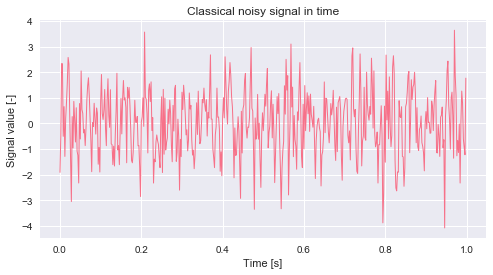

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, f, linewidth=1)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal value [-]')
ax.set_title('Classical noisy signal in time')

In [17]:
fhat = fftpack.fft(f)
xi = np.linspace(0, Fs, n, endpoint=False)
mag = np.abs(fhat)

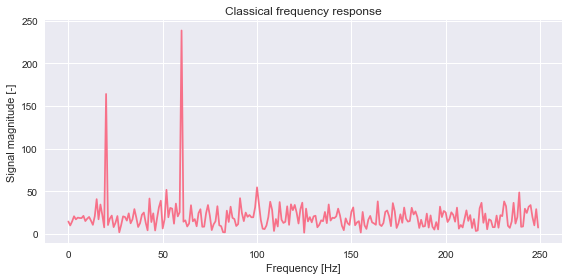

In [18]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(xi[:(n // 2)], mag[:(n //2)])
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Signal magnitude [-]')
ax.set_title('Classical frequency response')
plt.tight_layout()

# The Graph Laplacian

For each vertex $i$, the Laplace operator computes the weighted sum of the
differences between the signal value at $i$ and the signal value at $i's$
neighbors ($j \in N_i$). 

#### The Laplacian is a difference operator
  \begin{equation}
    (\Delta f) (i) = (L f) (i) = \sum_{j \in N_i} W_{i, j} [f(i) - f(j)]
  \end{equation}

The Laplace operator for an undirected graph is simply the degree matrix minus the
adjacency matrix.

#### The Graph Laplacian
  \begin{equation}
    L = D - W
  \end{equation}

$L$ will have a full set of orthonormal eigenvectors, and real eigenvalues. Zero
will occur as an eigenvalue with multiplicity equal to the number of connected
components.


# Graph Fourier transform

The Graph Fourier transform is an expansion of $f$ in terms of the eigenvectors $u_l$ of the Graph Laplacian.
  
#### The Graph Fourier Transform

\begin{equation}
  \hat{f}(\lambda_l) = \sum_{i=1}^N f(i) u^*_l(i) 
\end{equation}

- Eigenvectors associated with the smallest eigenvalues vary slowly across the graph.
- Eigenvectors associated with the largest eigenvalues oscillate rapidly.

# Fourier transform on a ring graph

In [19]:
n = 500
Aring = np.roll(np.eye(n), -1, axis=1) + np.roll(np.eye(n), 1, axis=1)

In [20]:
Lring = csgraph.laplacian(Aring)
l, u = linalg.eigh(Lring)

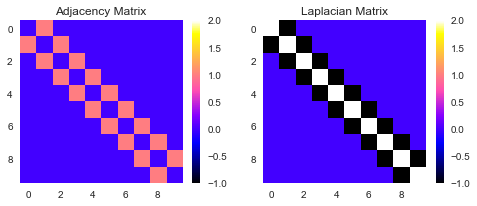

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))

im0 = ax[0].imshow(Aring[:10,:10], cmap='gnuplot2', vmin=-1, vmax=2)
im1 = ax[1].imshow(Lring[:10,:10], cmap='gnuplot2', vmin=-1, vmax=2)
plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
ax[0].grid('off')
ax[1].grid('off')

ax[0].set_title('Adjacency Matrix')
ax[1].set_title('Laplacian Matrix')

In [22]:
ghat = np.asarray([(f*u[:, w]).sum() for w in range(len(l))])
ghat = (f @ u)
g = u @ ghat

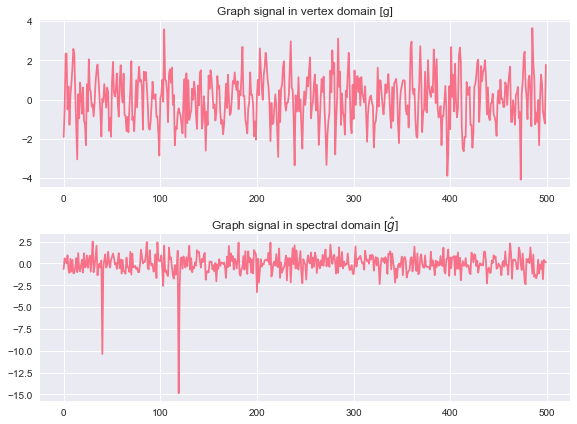

In [23]:
fig, ax = plt.subplots(2, figsize=(8,6))

ax[0].plot(g)
ax[1].plot(ghat)

ax[0].set_title(r'Graph signal in vertex domain [g]')
ax[1].set_title(r'Graph signal in spectral domain [$\hat{g}$]')

plt.tight_layout()

# Fourier transform on Minnesota road network

### Load data

In [24]:
minn = io.loadmat('../data/minnesota.mat')

In [25]:
Aroads = minn['Problem'][0][0][2]
xy = minn['Problem'][0][0][8][0][0][0]

### Isolate largest connected component

In [26]:
numcomp, components = sparse.csgraph.connected_components(Aroads)
compsize = np.max(np.bincount(components))
biggestcomp = np.argmax(np.bincount(components))
in_component = np.where(components == biggestcomp)[0]

Aroads = Aroads.todense()
Aroads = Aroads[in_component][:, in_component]
Aroads = sparse.csc_matrix(Aroads)

xy = xy[in_component]

In [27]:
links = np.where(Aroads.todense())
startcoords = xy[links[0]]
endcoords = xy[links[1]]
lines = [[tuple(x), tuple(y)] for x, y in zip(startcoords, endcoords)]

### Plot road network

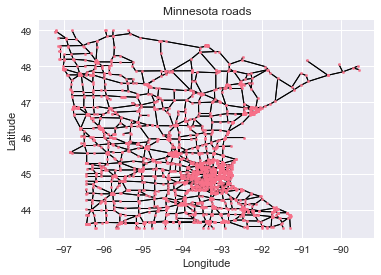

In [28]:
fig, ax = plt.subplots()

lc = collections.LineCollection(lines, linewidths=1, colors='k')

ax.add_collection(lc)
ax.scatter(xy[:, 0], xy[:, 1], s=6, zorder=2)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Minnesota roads')

# Eigendecomposition of the Laplacian carries frequency information

In [29]:
Lroads = csgraph.laplacian(Aroads)
l, u = np.linalg.eigh(Lroads.todense())
u = np.asarray(u)

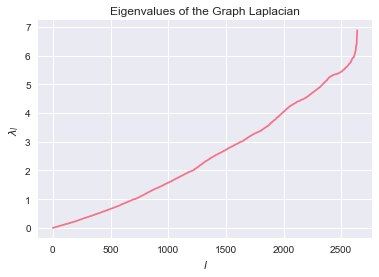

In [30]:
fig, ax = plt.subplots()
ax.plot(l)
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$\lambda_l$')
ax.set_title('Eigenvalues of the Graph Laplacian')

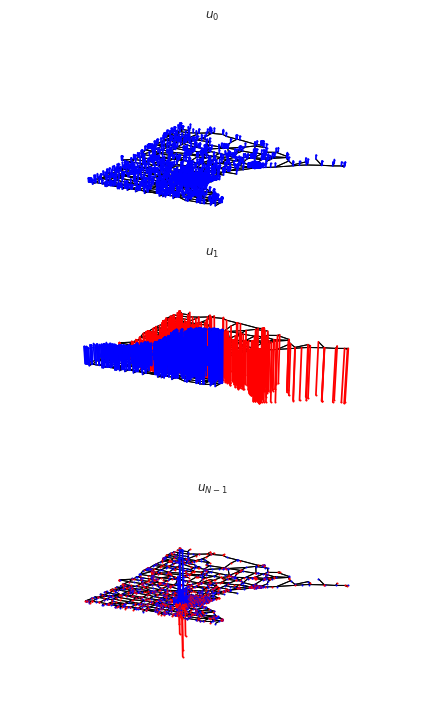

In [31]:
fig = plt.figure(figsize=(6,10))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(3, 1, 1, projection='3d')
graph3d(xy[:,0], xy[:,1], u[:, 0], zmin=0, zmax=0.5, fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$u_0$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax1 = fig.add_subplot(3, 1, 2, projection='3d')
graph3d(xy[:,0], xy[:,1], u[:, 1], fig=fig, ax=ax1, lc=lc)
ax1.set_title(r'$u_1$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax2 = fig.add_subplot(3, 1, 3, projection='3d')
graph3d(xy[:,0], xy[:,1], u[:, -1], fig=fig, ax=ax2, lc=lc)
ax2.set_title(r'$u_{N-1}$')

plt.tight_layout()

# Kernels on graphs

## Heat kernel

In [32]:
ghat = np.exp(-5*l)

In [33]:
g = sum([ghat[i] * u[:, i] for i in range(len(l))])
g = u @ ghat

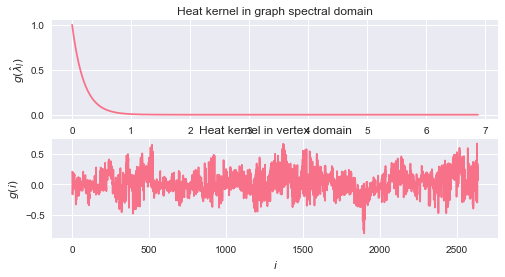

In [34]:
fig, ax = plt.subplots(2, figsize=(8, 4))

ax[0].set_title('Heat kernel in graph spectral domain')
ax[0].plot(l, ghat)
ax[0].set_xlabel(r'$\lambda_l$')
ax[0].set_ylabel(r'$\hat{g(\lambda_l)}$')

ax[1].set_title('Heat kernel in vertex domain')
ax[1].plot(np.arange(len(g)), g)
ax[1].set_xlabel(r'$i$')
ax[1].set_ylabel(r'$g(i)$')

## Putting the heat kernel in the vertex domain

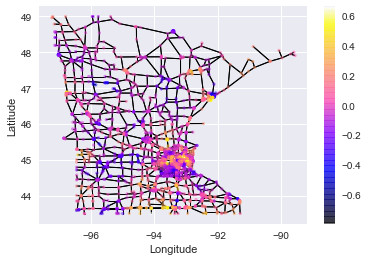

In [35]:
fig, ax = plt.subplots()

lc = collections.LineCollection(lines, linewidths=1, colors='k')

li = ax.add_collection(lc)
sc = ax.scatter(xy[:, 0], xy[:, 1], s=8, c=g, alpha=0.5,
                zorder=2, cmap='gnuplot2', vmin=g.min(), vmax=g.max())
plt.colorbar(sc, ax=ax)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

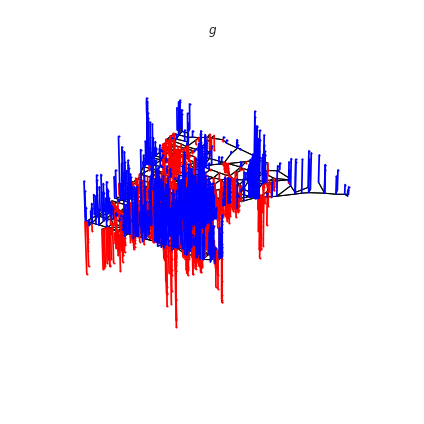

In [36]:
fig = plt.figure(figsize=(6,6))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(1, 1, 1, projection='3d')
graph3d(xy[:,0], xy[:,1], g, fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$g$')

# Translation

#### Classical translation operation
\begin{equation}
      (T_vf)(t) = f(t - v) = (f * \delta_v)(t)
    \end{equation}

  Again, we cannot directly generalize $(t - v)$ for a graph, so we consider
  instead the definition of translation as convolution with a Dirac delta. 
  
#### Translation of a graph signal
\begin{equation}
     (T_n f)(i) = \sqrt{N} (f * \delta_n)(i) = \sqrt{N} \sum_{l=0}^{N-1} \hat{f}(\lambda_l) u_l^*(n) u_l(i)
    \end{equation}

Where:

\begin{equation}
  \delta_n =
  \begin{cases}
    1 \ if \ i=n \\
    0 \ otherwise
  \end{cases}
\end{equation}


In [37]:
g_t = {}

for n in (0, 100, 150, 200, 2000, -1):
    g_t[n] = sum([ghat[w]*u[:, w][n]*u[:, w] for w in range(len(l))])

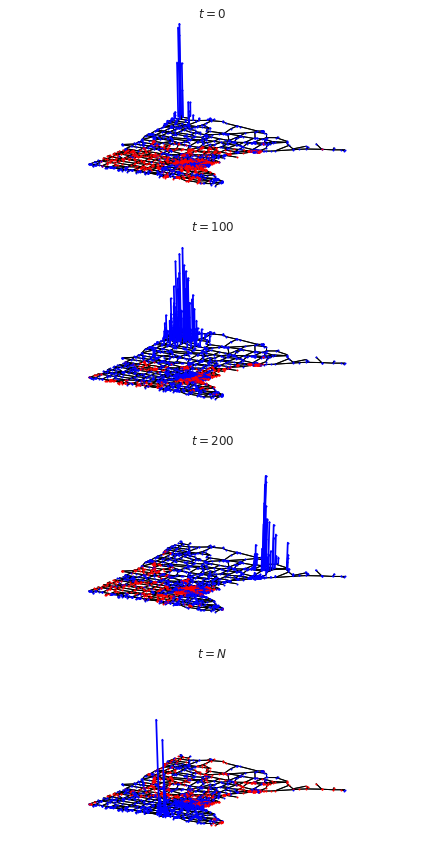

In [38]:
fig = plt.figure(figsize=(6,12))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(4, 1, 1, projection='3d')
graph3d(xy[:,0], xy[:,1], g_t[0], fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$t=0$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax1 = fig.add_subplot(4, 1, 2, projection='3d')
graph3d(xy[:,0], xy[:,1], g_t[100], fig=fig, ax=ax1, lc=lc)
ax1.set_title(r'$t=100$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax2 = fig.add_subplot(4, 1, 3, projection='3d')
graph3d(xy[:,0], xy[:,1], g_t[200], fig=fig, ax=ax2, lc=lc)
ax2.set_title(r'$t=200$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax3 = fig.add_subplot(4, 1, 4, projection='3d')
graph3d(xy[:,0], xy[:,1], g_t[-1], fig=fig, ax=ax3, lc=lc)
ax3.set_title(r'$t=N$')

plt.tight_layout()

# Filtering and convolution

Using some transfer function $\hat{h}$, we can filter an input signal as follows:

#### Classical frequency filtering
\begin{equation}
      f_{out}(t) = \mathcal{F}^{-1} \{ \hat{f}_{in}(\xi) \hat{h}(\xi)\}
\end{equation}

In the graph setting:
  
#### Graph filtering in the graph spectral domain
\begin{equation}
      \begin{split}
        \hat{h}(L) = U
        \begin{bmatrix}
          \hat{h}(\lambda_0) & & 0 \\
           & \ddots & \\
          0 & & \hat{h}(\lambda_{N-1})
        \end{bmatrix}
        U^*
      \\\\
      f_{out} = \hat{h}(L) f_{in}
      \end{split}
    \end{equation}

## Gaussian filter

In [39]:
def gaussian_filter(f, std=1):
    return np.exp(-(f**2 / (2*std**2)))

In [40]:
hhat = u @ np.diag(gaussian_filter(l, std=0.2)) @ u.T

In [41]:
gnoisy = 4*g_t[150] + 0.03*np.random.randn(len(g))

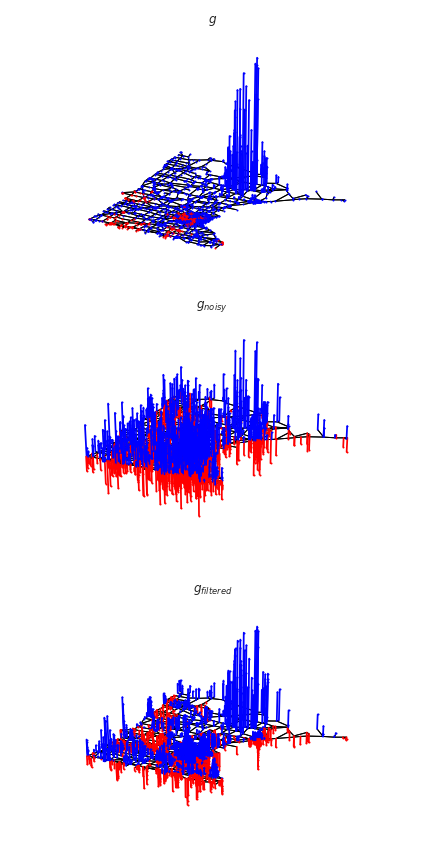

In [42]:
fig = plt.figure(figsize=(6,12))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(3, 1, 1, projection='3d')
graph3d(xy[:,0], xy[:,1], g_t[150], fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$g$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax1 = fig.add_subplot(3, 1, 2, projection='3d')
graph3d(xy[:,0], xy[:,1], gnoisy, fig=fig, ax=ax1, lc=lc)
ax1.set_title(r'$g_{noisy}$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax2 = fig.add_subplot(3, 1, 3, projection='3d')
graph3d(xy[:,0], xy[:,1], hhat @ gnoisy, fig=fig, ax=ax2, lc=lc)
ax2.set_title(r'$g_{filtered}$')

plt.tight_layout()

## Remove high-frequency eigenvalues

In [43]:
hhat = u @ np.diag(np.where(l < l[100], l, 0)) @ u.T

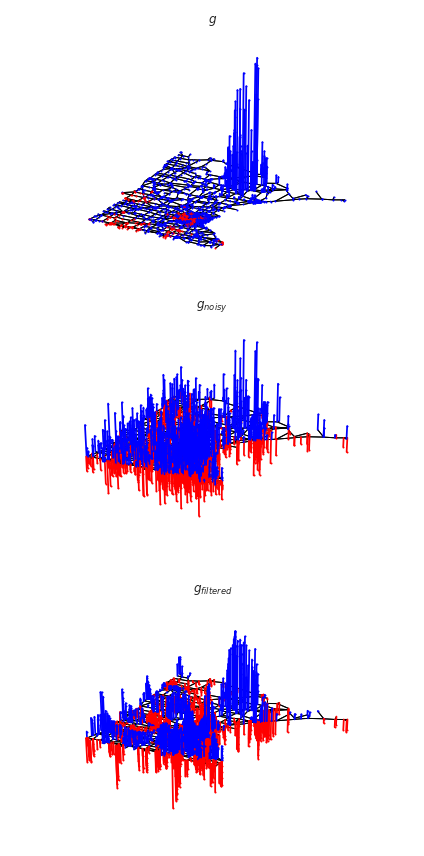

In [44]:
fig = plt.figure(figsize=(6,12))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(3, 1, 1, projection='3d')
graph3d(xy[:,0], xy[:,1], g_t[150], fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$g$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax1 = fig.add_subplot(3, 1, 2, projection='3d')
graph3d(xy[:,0], xy[:,1], gnoisy, fig=fig, ax=ax1, lc=lc)
ax1.set_title(r'$g_{noisy}$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax2 = fig.add_subplot(3, 1, 3, projection='3d')
graph3d(xy[:,0], xy[:,1], hhat @ gnoisy, fig=fig, ax=ax2, lc=lc)
ax2.set_title(r'$g_{filtered}$')

plt.tight_layout()

# Modulation

In [45]:
g = g_t[150]
N = Aroads.shape[0]

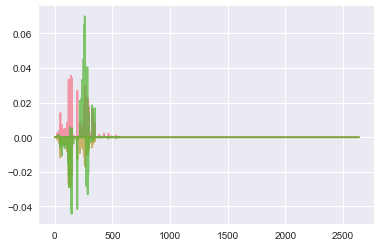

In [46]:
plt.plot(g, alpha=0.7)
plt.plot(np.sqrt(N) * u[:, 20] * g, alpha=0.7)
plt.plot(np.sqrt(N) * u[:, 100] * g, alpha=0.7)

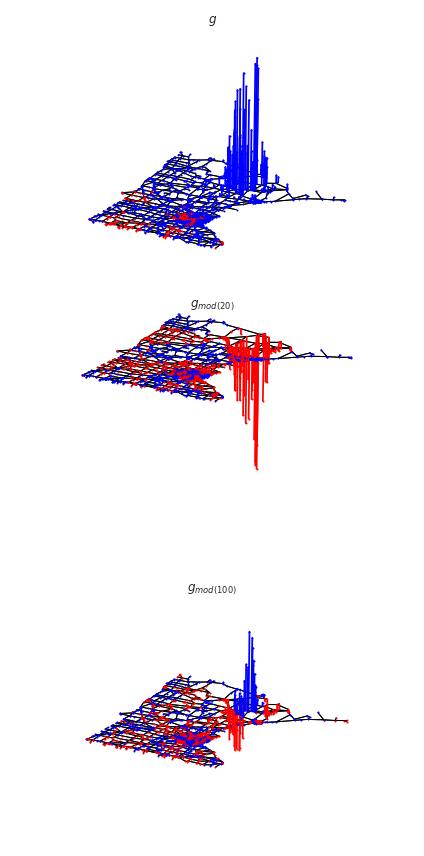

In [47]:
fig = plt.figure(figsize=(6,12))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(3, 1, 1, projection='3d')
graph3d(xy[:,0], xy[:,1], g, fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$g$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax1 = fig.add_subplot(3, 1, 2, projection='3d')
graph3d(xy[:,0], xy[:,1], np.sqrt(N) * u[:, 20] * g, fig=fig, ax=ax1, lc=lc)
ax1.set_title(r'$g_{mod(20)}$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax2 = fig.add_subplot(3, 1, 3, projection='3d')
graph3d(xy[:,0], xy[:,1], np.sqrt(N) * u[:, 100] * g, fig=fig, ax=ax2, lc=lc)
ax2.set_title(r'$g_{mod(100)}$')

plt.tight_layout()

# Dilation